{/* cspell:ignore IIIZ IZII IIZI ZIII IZIZ IIZZ ZIIZ IZZI ZZII ZIZI XXYY YYXX ansätze ansatze infty IZZX XIYX ZZXZ ZZZX IIXX IIXZ IZXZ IXXZ XZXZ ZIXZ */}

# The variational quantum eigensolver (VQE)

This lesson will introduce the variational quantum eigensolver, explain its importance as a foundational algorithm in quantum computing, and also explore its strengths and weaknesses. VQE by itself, without augmenting methods, is not likely to be sufficient for modern utility scale quantum computations. It is nevertheless important as an archetypal classical-quantum hybrid method, an it is an important foundation upon which many more advanced algorithms are built.

This video gives an overview of VQE and factors that affect its efficiency. The text below adds more detail and implements VQE using Qiskit.

<IBMVideo id="134325519" title="In this video, Chris Porter describes key components of the variational quantum eigensolver. These include the Hamiltonian, the ansatz, a classical optimizer and an estimator. He also discusses what factors affect the efficiency of VQE."/>

## 1. What is VQE?

The variational quantum eigensolver is an algorithm that uses classical and quantum computing in conjunction to accomplish a task. There are 4 main components of a VQE calculation:

* __An operator__: Often a Hamiltonian, which we’ll call $H$, that describes a property of your system that you wish to optimize. Another way of saying this is that you are seeking the eigenvector of this operator that corresponds to the minimum eigenvalue. We often call that eigenvector the “ground state”.
* __An “ansatz”__ (a German word meaning “approach”): this is a quantum circuit that prepares a quantum state approximating the eigenvector you’re seeking. Really the ansatz is a family of quantum circuits, because some of the gates in the ansatz are parametrized, that is, they are fed a parameter which we can vary. This family of quantum circuits can prepare a family of quantum states approximating the ground state.
* __An estimator__: a means of estimating the expectation value of the operator $H$  over the current variational quantum state. Sometimes what we really care about is simply this expectation value, which we call a cost function. Sometimes, we care about a more complicated function that can still be written starting from one or more expectation values.
* __A classical optimizer__: an algorithm that varies parameters to try to minimize the cost function.

Let's look at each of these components in more depth.

### 1.1 The operator (Hamiltonian)

At the core of a VQE problem is an operator that describes a system of interest. We will assume here that the lowest eigenvalue and the corresponding eigenvector of this operator are useful for some scientific or business purpose. Examples might include a chemical Hamiltonian describing a molecule, such that the lowest eigenvalue of the operator corresponds to the ground state energy of the molecule, and the corresponding eigenstate describes the geometry or electron configuration of the molecule. Or the operator could describe a cost of a certain process to be optimized, and the eigenstates could correspond to routes or practices. In some fields, like physics, a "Hamiltonian" almost always refers to an operator describing the energy of a physical system. But in quantum computing, it is common to see quantum operators that describe a business or logistical problem also referred to as a "Hamiltonian". We will adopt that convention here.

![An image of atomic orbitals and an image of a network of many nodes and connections between them.](/learning/images/courses/quantum-diagonalization-algorithms/vqe/vqe-fig1.avif)

Mapping a physical or optimization problem to qubits is typically a non-trivial task, but those details are not the focus of this course. A general discussion of mapping a problem to a quantum operator can be found in [Quantum computing in practice](/learning/courses/quantum-computing-in-practice). A more detailed look at the mapping of chemistry problems into quantum operators can be found in [Quantum Chemistry with VQE](/learning/courses/quantum-chem-with-vqe).

For the purposes of this course, we will assume the form of the Hamiltonian is known. For example, a Hamiltonian for a simple hydrogen molecule (under certain active space assumptions, and using the Jordan-Wigner mapper) is:

In [2]:
from qiskit.quantum_info import SparsePauliOp

hamiltonian = SparsePauliOp(
    [
        "IIII",
        "IIIZ",
        "IZII",
        "IIZI",
        "ZIII",
        "IZIZ",
        "IIZZ",
        "ZIIZ",
        "IZZI",
        "ZZII",
        "ZIZI",
        "YYYY",
        "XXYY",
        "YYXX",
        "XXXX",
    ],
    coeffs=[
        -0.09820182 + 0.0j,
        -0.1740751 + 0.0j,
        -0.1740751 + 0.0j,
        0.2242933 + 0.0j,
        0.2242933 + 0.0j,
        0.16891402 + 0.0j,
        0.1210099 + 0.0j,
        0.16631441 + 0.0j,
        0.16631441 + 0.0j,
        0.1210099 + 0.0j,
        0.17504456 + 0.0j,
        0.04530451 + 0.0j,
        0.04530451 + 0.0j,
        0.04530451 + 0.0j,
        0.04530451 + 0.0j,
    ],
)

Note that in the Hamiltonian above, there are terms like `ZZII` and `YYYY` that do not commute with each other. That is, to evaluate `ZZII`, we would need to measure the Pauli Z operator on qubit 3 (among other measurements). But to evaluate `YYYY`, we need to measure the Pauli Y operator on that same qubit, qubit 3. There is an uncertainty relation between Y and Z operators on the same qubit; we cannot measure both of those operators at the same time. We will revisit this point below, and indeed throughout the course.
The Hamiltonian above is a $16\times 16$ matrix operator. Diagonalizing the operator to find its lowest energy eigenvalue is not difficult.

In [3]:
import numpy as np

A = np.array(hamiltonian)
eigenvalues, eigenvectors = np.linalg.eigh(A)
print("The ground state energy is ", min(eigenvalues), "hartrees")

The ground state energy is  -1.1459778447627311 hartrees


Brute force classical eigensolvers cannot scale to describe the energies or geometries of very large systems of atoms, like medications or proteins. VQE is one of the early attempts to leverage quantum computing in this problem.

We will encounter Hamiltonians in this lesson much larger than that above. But it would be wasteful to push the limits of what VQE can do, before we introduce some of the more advanced tools that can augment or replace VQE, later in this course.

### 1.2 Ansatz

The word "ansatz" is German for "approach". The correct plural in German is "ansätze", though one often sees "ansatzes" or "ansatze". In the context of VQE, an ansatz is the quantum circuit you use to create a multi-qubit wave function that most closely approximates the ground state of the system you are studying, and which thus produces the lowest expectation value of your operator. This quantum circuit will contain variational parameters (often collected together in the vector of variables $\vec{\theta}$).

![An image of a quantum circuit with variational parameters labeled "theta".](/learning/images/courses/quantum-diagonalization-algorithms/vqe/vqe-fig2.avif)

An initial set of values $\vec{\theta_0}$ of the variational parameters is chosen. We will call the unitary operation of the ansatz on the circuit $U_{\text{var}}(\vec{\theta_0})$. By default, all qubits in IBM quantum computers are initialized to the $|0\rangle$ state. When the circuit is run, the state of the qubits will be

$$
|\psi(\vec{\theta_0})\rangle=U_{\text{var}}(\vec{\theta_0})|0\rangle^{\otimes N}
$$

If all we needed were the lowest energy (using the language of physical systems), we could estimate this by simply measuring the energy many times and taking the lowest. But we typically also want the configuration that yields that lowest energy or eigenvalue. So the next step is the estimation of the expectation value of the Hamiltonian, which is accomplished through quantum measurements. A lot goes into that. But we can understand this process qualitatively by noting that the probability $P_j$ of measuring an energy $E_j$ (again using the language of physical systems) is related to the expectation value by:

$$
\langle \psi(\vec{\theta_0}) |H|\psi (\vec{\theta_0}) \rangle
$$

The probability $P_j$ is also related to the overlap between the eigenstate $|\phi_j\rangle$ and the current state of the system $|\psi(\vec{\theta_0})\rangle$:

$$
P_j=|\langle \phi_j|\psi(\vec{\theta_0})\rangle|^2 = |\langle \phi_j|U_{\text{var}}(\vec{\theta_0})|0\rangle^{\otimes N}|^2
$$

So by making many measurements of the Pauli operators making up our Hamiltonian, we can estimate the Hamiltonian's expectation value in the current state of the system $|\psi(\vec{\theta_0})\rangle$. The next step is to vary the parameters $\vec{\theta}$ and try to more closely approach the lowest-energy (ground) state of the system. Because of the variational parameters in the ansatz, one sometimes hears it referred to as the __variational form__.

Before we move on to that variational process, note that it is often useful to start your state from a "good guess" state. You might know enough about your system to make a better initial guess than $|0\rangle^{\otimes N}$. For example, it is common to initialize qubits to the Hartree-Fock state in chemical applications. This starting guess which does not contain any variational parameters is called the __reference state__. Let us call the quantum circuit used to create reference state $U_{ref}$. Whenever it becomes important to distinguish the reference state from the rest of the ansatz, use: $U_{\text{ansatz}}(\vec{\theta}) =U_{\text{var}}(\vec{\theta})U_{\text{ref}}.$ Equivalently

$$
\begin{aligned}
|\psi_{\text{ref}}\rangle&=U_{\text{ref}}|0\rangle^{\otimes N}\\
|\psi_{\text{ansatz}}(\vec{\theta})\rangle&=U_{var}(\vec{\theta})|\psi_{\text{ref}}\rangle = U_{\text{var}}(\vec{\theta})U_{\text{ref}}|0\rangle^{\otimes N}.
\end{aligned}
$$

### 1.3 Estimator

We need a way to estimate the expectation value of our Hamiltonian in a particular variational state $|\psi(\vec{\theta})\rangle$. If we could directly measure the entire operator $H$, this would be as simple as making many (say $N$) measurements and averaging the measured values:

$$
\langle \psi(\vec{\theta})|H|\psi(\vec{\theta})\rangle _N \approx \frac{1}{N}\sum_{j=1}^N {E_j}
$$
Here, the $\approx$ symbol reminds us that this expectation value would only be precisely correct in the limit as $N\rightarrow \infty$. But with thousands of measurements being made on a circuit, the sampling error of the expectation value is fairly low. There are other considerations such as noise that become an issue for very precise calculations.

However, it is generally not possible to measure $H$ all at once. $H$ may contain multiple non-commuting Pauli X, Y, and Z operators. So the Hamiltonian must be broken up into groups of operators that can be simultaneously measured, and each such group must be estimated separately, and the results combined to obtain an expectation value. We will revisit this in greater detail in the next lesson, when we discuss the scaling of classical and quantum approaches. This complexity in measurement is one reason we need highly efficient code for carrying out such estimation. In this lesson and beyond, we will use the Qiskit Runtime primitive Estimator for this purpose.

### 1.4 Classical optimizers

A classical optimizer is any classical algorithm designed to find extrema of a target function (typically a minimum). They search through the space of possible parameters looking for a set that minimizes some function of interest. They can be broadly categorized into gradient-based methods, which utilize gradient information, and gradient-free methods, which operate as black-box optimizers. The choice of classical optimizer can significantly impact an algorithm's performance, especially in the presence of noise in quantum hardware. Popular optimizers in this field include Adam, AMSGrad, and SPSA, which have shown promising results in noisy environments. More traditional optimizers include COBYLA and SLSQP.

A common workflow (demonstrated in Section 3.3) is to use one of these algorithms as the method inside a minimizer like scipy's ```minimize``` function. This takes as its arguments:
* Some function to be minimized. This is often the energy expectation value. But these are generally referred to as "cost functions".
* A set of parameters from which to begin the search. Often called $x_0$ or $\theta_0$.
* Arguments, including arguments of the cost function. In quantum computing with Qiskit, these arguments will include the ansatz, the Hamiltonian, and the estimator, which is discussed more in the next subsection.
* A 'method' of minimization. This refers to the specific algorithm used to search the parameter space. This is where we would specify, for example, COBYLA or SLSQP.
* Options. The options available may differ by method. But an example which practically all methods would include is the maximum number of iterations of the optimizer before ending the search: 'maxiter'.

![An image showing a curved line representing energy with several points at which the value is being tested to find the minimum.](/learning/images/courses/quantum-diagonalization-algorithms/vqe/vqe-fig3.avif)

At each iterative step, the expectation value of the Hamiltonian is estimated by making many measurements. This estimated energy is returned by the cost function, and the minimizer updates the information it has about the energy landscape. Exactly what the optimizer does to choose the next step varies from method to method. Some use gradients and select the direction of steepest descent. Others may take noise into account and may require that the cost decrease by a large margin before accepting that the true energy decreases along that direction.

In [4]:
# Example syntax for minimization
# from scipy.optimize import minimize
# res = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="cobyla", options={'maxiter': 200})

### 1.5 The variational principle

In this context the variational principle is very important; it states that no variational wave function can yield an energy (or cost) expectation value lower than that yielded by the ground state wave function. Mathematically,
$$
E_\text{var}=\langle \psi_\text{var}|H|\psi_\text{var}\rangle \geq E_\text{min}=\langle \psi_\text{0}|H|\psi_\text{0}\rangle
$$
This is easy to verify if we note that the set of all eigenstates $\{|\psi_0\rangle, |\psi_1\rangle, |\psi_2\rangle, ...|\psi_n \rangle\}$ of $H$ form a complete basis for the Hilbert space. In other words, any state and in particular $|\psi_\text{var}\rangle$ can be written as a weighted (normalized) sum of these eigenstates of $H$:
$$
|\psi_\text{var}\rangle=\sum_{i=0}^n c_i |\psi_i\rangle
$$
where $c_i$ are constants to be determined, and $\sum_{i=0} |c_i|^2 = 1$. We leave this as an exercise to the reader. But note the implication: the variational state that produces the lowest-energy expectation value *is* the best estimate of the true ground state.

#### Check your understanding
Read the question below, think about your answer, then click the triangle to reveal the solution.

<details>
<summary>

Verify mathematically that $E_\text{var}\geq E_0$ for any variational state $|\psi_\text{var}\rangle$.

</summary>

__Answer:__

Using the given expansion of the variational state in terms of the energy eigenstates,
$$
|\psi_\text{var}\rangle=\sum_{i=0}^n c_i |\psi_i\rangle,
$$
we can write the variational energy expectation value as
$$
\begin{aligned}
E_\text{var}&=\langle \psi_\text{var}|H|\psi_\text{var}\rangle =\left(\sum_{i=0}^n c^*_i \langle \psi_i|\right)H\left(\sum_{j=0}^n c_j |\psi_j\rangle\right)\\
&=\left(\sum_{i=0}^n c^*_i \langle \psi_i|\right)\left(\sum_{j=0}^n c_j E_j|\psi_j\rangle\right)\\
&=\sum_{i,j=0}^n c^*_i c_j E_j \langle \psi_i|\psi_j\rangle\\
&=\sum_{i,j=0}^n c^*_i c_j E_j \delta_{i,j}\\
&=\sum_{i=0}^n |c_i|^2 E_i.
\end{aligned}
$$
For all coefficients $0\leq|c_i|^2\leq 1$. So we can write
$$
\begin{aligned}
E_\text{var}&=\sum_{i=0}^n |c_i|^2 E_i\geq \sum_{i=0}^n |c_i|^2 E_0 = E_0 \sum_{i=0}^n |c_i|^2 = E_0(1) \\
E_\text{var}&\geq E_0
\end{aligned}
$$

</details>

## 2. Comparison with classical workflow

Let’s say we are interested in a matrix with N rows and N columns. Suppose your matrix is so large that exact diagonalization is not an option. Suppose further that you know enough about your problem that you can make some guesses about the overall structure of the target eigenstate, and you want to probe states similar to your initial guess to see if your cost/energy can be lowered further. This is a variational approach, and it is one method that is used when exact diagonalization is not an option.

### 2.1 Classical workflow

Using a classical computer, this would work as follows:
* Make a guess state, with some parameters $\vec{\theta}_i$ that you will vary: $|\psi(\vec{\theta}_i)\rangle$. Although this initial guess could be random, that is not advisable. We want to use knowledge of the problem at hand to tailor our guess as much as possible.
* Calculate the expectation value of the operator with the system in that state: $\langle\psi(\vec{\theta}_i)|H|\psi(\vec{\theta}_i)\rangle$
* Alter the variational parameters and repeat: $\vec{\theta}_i\rightarrow \vec{\theta}_{i+1}$.
* Use accumulated information about the landscape of possible states in your variational subspace to make better and better guesses and approach the target state. The variational principle guarantees that our variational state cannot yield an eigenvalue lower than that of the target ground state. So the lower the expectation value the better our approximation of the ground state:
$$
\min_{\vec{\theta}} \{ E_{\text{var},i} = \langle\psi(\vec{\theta_i})|H|\psi(\vec{\theta_i})\rangle \} \geq E_0
$$
Let us examine the difficulty of each step in this approach. Setting or updating parameters is computationally easy; the difficulty there is in selecting useful, physically motivated initial parameters. Using accumulated information from prior iterations to update parameters in such a way that you approach the ground state is a non-trivial. But classical optimization algorithms exist that do this quite efficiently. This classical optimization is only expensive because it may require many iterations; in the worst case, the number of iterations may scale exponentially with N. The most computationally expensive single step is almost certainly calculating the expectation value of your matrix using a given state $|\psi(\vec{\theta_i})\rangle$: $\langle\psi(\vec{\theta_i})|H|\psi(\vec{\theta_i})\rangle.$

The $N\times N$ matrix must act on the $N$-element vector, which corresponds to: $O(N^2)$ multiplication operations in the worst case. This must be done at each iteration of parameters. For extremely large matrices, this has high computational cost.

### 2.2 Quantum workflow and commuting Pauli groups

Now imagine relegating this portion of the calculation to a quantum computer. Instead of calculating this expectation value, you estimate it by preparing the state $|\psi(\vec{\theta_i})\rangle$ on the quantum computer using your variational ansatz, and then making measurements.

That may sound easier than it is. $H$ is generally not easy to measure. For example it could be made up of many non-commuting Pauli X, Y, and Z operators. But $H$ __can__ be written as a linear combination of terms, $h_\alpha$, each of which is easily measurable (e.g. Pauli operators or groups of qubit-wise commuting Pauli operators).
The expectation value of $H$ over some state $|\Psi\rangle$ is the weighted sum of expectation values of the constituent  terms $h_\alpha$. This expression holds for any state $|\Psi⟩$, but we will specifically be using this with our variational states $|\psi(\theta_i)\rangle$.

$$
H = \sum_{\alpha = 1}^T{c_\alpha h_\alpha}
$$
where $h_\alpha$ is a Pauli string like `IZZX…XIYX`, or several such strings that commute with each other. So a description of the expectation value that more closely matches the realities of measurement on quantum computers is
$$
\langle \Psi |H|\Psi \rangle =\sum_{\alpha} c_\alpha \langle \Psi | h_\alpha|\Psi \rangle.
$$
And in the context of our variational wave function:
$$
\langle \psi(\vec{\theta}_i) |H|\psi(\vec{\theta}_i) \rangle =\sum_{\alpha} c_\alpha \langle \psi(\vec{\theta}_i) | h_\alpha|\psi(\vec{\theta}_i) \rangle
$$
Each of the terms $h_\alpha$ can be measured $M$ times yielding measurement samples $s_{\alpha j}$ with $j=1…M$ and returns an expectation value $\mu_\alpha$ and a standard deviation $\sigma_\alpha$. We can sum these terms and propagate errors through the sum to obtain an overall expectation value $\mu$ and standard deviation $\sigma$.

$$
\begin{aligned}
\langle \psi(\vec{\theta}_i) |h_\alpha|\psi(\vec{\theta}_i) \rangle &\simeq \mu _\alpha \pm \frac{\sigma_\alpha}{\sqrt{M}} &\qquad \mu_\alpha &=\frac{1}{M}\sum_j s_{\alpha,j} &\qquad \sigma^2_\alpha &=\frac{1}{M-1}\sum_j (s_{\alpha,j}-\mu_\alpha)^2\\

\langle \psi(\vec{\theta}_i) |H|\psi(\vec{\theta}_i) \rangle &\simeq \mu  \pm \sigma &\qquad \mu &= \sum_\alpha c_\alpha \mu_\alpha &\qquad \sigma^2&=\sum_\alpha c^2_\alpha \frac{\sigma^2_\alpha }{M}

\end{aligned}
$$

This requires no large-scale multiplication, nor any process that necessarily scales like $N^2$. Instead it requires multiple measurements on the quantum computer. If you don’t need too many of those, this approach could be efficient. And that’s the quantum part of VQE.

But let’s talk about reasons why this might not be efficient. One reason for many measurements is to reduce the statistical uncertainty in your estimates, for very high-precision calculations. Another reason is the number of Pauli strings required to span your entire matrix. Because Pauli matrices (plus the identity: X, Y, Z, and I) span the space of all operators of a given dimension, we are guaranteed that we can write our matrix of interest as a weighted sum of Pauli operators, as we did before.
$$
H = \sum_{\alpha = 1}^T{c_\alpha h_\alpha}
$$
where $h_\alpha$ is a Pauli string acting on all the qubits describing your system like `IZZX…XIYX`, or several such strings that commute with each other. Recall that Qiskit uses *little endian* notation, in which the $n^\text{th}$ Pauli operator from the right acts on the $n^\text{th}$ qubit. So we can measure our operator by measuring a series of Pauli operators.

But we cannot measure all those Pauli operators simultaneously. Pauli operators (excluding I) do not commute with each other if they are associated with the same qubit. For example, we can measure `IZIZ` and `ZZXZ` simultaneously, because we can measure I and Z simultaneously for the 3rd qubit, and we can know I and X simultaneously for the 1st qubit. But we cannot measure ZZZZ and ZZZX simultaneously, because Z and X do not commute, and both act on the 0th qubit.

![A table of different Pauli strings, some of which commute and others which do not.](/learning/images/courses/quantum-diagonalization-algorithms/vqe/vqe-fig4.avif)

So we decompose our matrix $H$ into a sum of Paulis acting on different qubits. Some elements of that sum can be measured all at once; we call this a *group of commuting Paulis*. Depending on how many non-commuting terms there are, we may need many such groups. Call the number of such groups of commuting Pauli strings $N_\text{GCP}$. If $N_\text{GCP}$ is small, this could work well. If $H$ has millions of groups, this will not be useful.

The processes required for estimation of the expectation value are collected together in the Qiskit Runtime primitive called Estimator. To learn more about Estimator, see the [API reference](/docs/api/qiskit-ibm-runtime/estimator-v2) in IBM Quantum Documentation. One can simply use Estimator directly, but Estimator returns much more than just the lowest energy eigenvalue. For example, it also returns information on ensemble standard error. Thus, in the context of minimization problems, one often sees Estimator inside a cost function. To learn more about Estimator inputs and outputs see this [guide](/docs/guides/primitive-input-output) on IBM Quantum Documentation.

You record the expectation value (or the cost function) for the set of parameters $\vec{\theta_i}$ used in your state, and then you update the parameters. Over time, you could use the expectation values or cost-function values you’ve estimated to approximate a gradient of your cost function in the subspace of states sampled by your ansatz. Both gradient-based, and gradient-free classical optimizers exist. Both suffer from potential trainability issues, like multiple local minima, and large regions of parameter space with near-zero gradient, called *barren plateaus*.

![Two images of a curved line with a minimum value. In one, points are randomly checked in the search for a minimum, in the other a gradient is estimated by drawing a line between two adjacent points.](/learning/images/courses/quantum-diagonalization-algorithms/vqe/vqe-fig5.avif)

### 2.3 Factors that determine computational cost

VQE will not solve all your toughest quantum chemistry problems. No. But being better at all calculations is not the point. We have shifted what determines the computational cost.

![A table comparing classical and quantum variational approaches. Both require good initial guesses. Classically, the cost scales like the dimension of your matrix squared, and in the quantum approach it depends on how many groups of commuting Pauli operators you have.](/learning/images/courses/quantum-diagonalization-algorithms/vqe/vqe-fig6.avif)

We’ve shifted from a process whose complexity depends only on matrix dimension to one that depends on required precision and the number of non-commuting Pauli operators that make up the matrix. The last bit has no analog in classical computing.

Based on these dependencies, for sparse matrices, or matrices involving few non-commuting Pauli strings, this process may be useful. This is the case for systems of interacting spins, for example. For dense matrices, it may be less useful. We know for example that chemical systems often have Hamiltonians that involve hundreds, thousands, even millions of Pauli strings. There has been interesting work done to reduce this number of terms. But chemical systems may be better suited to some of the other algorithms we will discuss in this course.

#### Check your understanding
Read the questions below, think about your answers, then click the triangles to reveal the solutions.

<details>
<summary>

Consider a Hamiltonian on four qubits that contains the terms:

`IIXX`, `IIXZ`, `IIZZ`, `IZXZ`, `IXXZ`, `ZZXZ`, `XZXZ`, `ZIXZ`, `ZZZZ`, `XXXX`

You wan to sort these terms into groups such that all terms in a group can be measured simultaneously. What is the smallest number of such groups you can make such that all terms are accounted for?

</summary>

__Answer:__

It can be done in 5 groups. Note that such solutions are typically not unique.

`IIXX`, `XXXX`

`IIXZ`, `IZXZ`, `ZZXZ`

`IIZZ`, `ZZZZ`

`IXXZ`, `ZIXZ`

`XZXZ`

</details>

<details>
<summary>

Which do you expect typically makes quantum chemistry with VQE difficult: the number of terms in the Hamiltonian, finding a good ansatz?

</summary>

__Answer:__

It turns out there are ansätze that are highly optimized for chemical contexts. The number of terms in the Hamiltonian, and hence the number of measurements required typically cause more problems.
</details>

## 3. Example Hamiltonian

Let us put this algorithm into practice using a small Hamiltonian matrix so that we can see what is happening in each step. We will employ the Qiskit patterns framework:

-__Step 1__: Map problem to quantum circuits and operators
-__Step 2__: Optimize for target hardware
-__Step 3__: Execute on target hardware
-__Step 4__: Post-process results


### 3.1 Step 1: Map the problem to quantum circuits and operators

We will use the one defined above from the chemistry context. We start with some general imports.

In [5]:
# General imports
import numpy as np

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

Again, we assume the Hamiltonian of interest is known. We will use an extremely small Hamiltonian here, because other methods discussed in this course will be more efficient at solving larger problems.

In [6]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np

hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

A = np.array(hamiltonian)
eigenvalues, eigenvectors = np.linalg.eigh(A)
print("The ground state energy is ", min(eigenvalues))

The ground state energy is  -0.702930394459531


There are many prefabricated ansatz choices in Qiskit. We will use ```efficient_su2```.

This circuit has  4 parameters


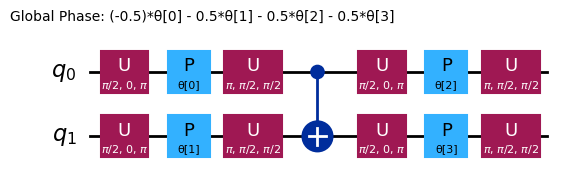

In [7]:
# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import efficient_su2

# Note that it is more common to place initial 'h' gates outside the ansatz. Here we specifically wanted this layer structure.
ansatz = efficient_su2(
    hamiltonian.num_qubits, su2_gates=["h", "rz", "y"], entanglement="circular", reps=1
)
num_params = ansatz.num_parameters
print("This circuit has ", num_params, "parameters")

ansatz.decompose().draw("mpl", style="iqp")

Different ansätze will have different entangling structures and different rotation gates. The one shown here uses CNOT gates for entangling, and parametrized RY and RZ gates. Note the size of this parameter space; it means we must minimize the cost function over 8 variables. This can be scaled up, but not indefinitely. Running a similar problem on 4 qubits, using the default 3 reps for ```efficient_su2``` yields 32 variational parameters.

### 3.2 Step 2: Optimize for target hardware

The ansatz was written using familiar gates, but our circuit must be transpiled to make use of the basis gates that can be implemented on each quantum computer. We select the least busy backend.

In [17]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

print(backend)

<IBMBackend('ibm_torino')>


We can now transpile our circuit for this hardware and visualize our transpiled ansatz.

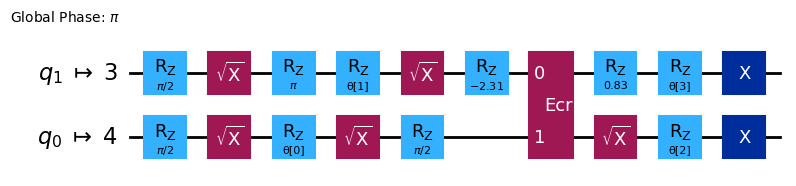

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

Note that the gates used have changed, and the qubits in our abstract circuit have been mapped to differently-numbered qubits on the quantum computer. We must map our Hamiltonian identically in order for our results to be meaningful.

In [10]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

### 3.3 Step 3: Execute on target hardware

#### 3.3.1 Reporting out values

We define a cost function here that takes as arguments the structures we have built in previous steps: the parameters, the ansatz, and the Hamiltonian. It also uses the estimator which we have not yet defined. We include code to track the history of our cost function, so that we can check convergence behavior.

In [11]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy


cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

It is highly advantageous if you can choose initial parameter values based on knowledge of the problem at hand and characteristics of the target state. We will make no assumptions of such knowledge and use random initial values.

In [12]:
x0 = 2 * np.pi * np.random.random(num_params)

In [13]:
# This required 13 min, 20 s QPU time on ibm_cusco, 28 min total time.
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
        options={"maxiter": 50},
    )

/home/porter284/.pyenv/versions/3.11.12/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


Iters. done: 1 [Current cost: 0.010575798722044727]
Iters. done: 2 [Current cost: 0.004040015974440895]
Iters. done: 3 [Current cost: 0.0020213258785942503]
Iters. done: 4 [Current cost: 0.18723082446726014]
Iters. done: 5 [Current cost: -0.2746792152068885]
Iters. done: 6 [Current cost: -0.3094547651648519]
Iters. done: 7 [Current cost: -0.05281985428356641]
Iters. done: 8 [Current cost: 0.00808560303514377]
Iters. done: 9 [Current cost: -0.0014821685303514388]
Iters. done: 10 [Current cost: -0.004759824281150161]
Iters. done: 11 [Current cost: 0.09942328705995292]
Iters. done: 12 [Current cost: 0.01092366214057508]
Iters. done: 13 [Current cost: 0.05017497496069776]
Iters. done: 14 [Current cost: 0.13028868414310696]
Iters. done: 15 [Current cost: 0.013747803514376994]
Iters. done: 16 [Current cost: 0.2583072432944498]
Iters. done: 17 [Current cost: -0.14422125655131562]
Iters. done: 18 [Current cost: -0.0004950150347678081]
Iters. done: 19 [Current cost: 0.00681082268370607]
Iters. 

We can look at the raw outputs.

In [14]:
res

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -0.5334241316590271
       x: [ 1.024e+00  6.459e+00  3.625e+00  4.007e+00]
    nfev: 39
   maxcv: 0.0

### 3.4 Step 4: Post-process results

If the procedure terminates correctly, then the values in our dictionary should be equal to the solution vector and total number of function evaluations, respectively. This is easy to verify:

In [15]:
cost_history_dict

{'prev_vector': array([1.02397956, 6.45886604, 3.62479262, 4.00744128]),
 'iters': 39,
 'cost_history': [np.float64(0.010575798722044727),
  np.float64(0.004040015974440895),
  np.float64(0.0020213258785942503),
  np.float64(0.18723082446726014),
  np.float64(-0.2746792152068885),
  np.float64(-0.3094547651648519),
  np.float64(-0.05281985428356641),
  np.float64(0.00808560303514377),
  np.float64(-0.0014821685303514388),
  np.float64(-0.004759824281150161),
  np.float64(0.09942328705995292),
  np.float64(0.01092366214057508),
  np.float64(0.05017497496069776),
  np.float64(0.13028868414310696),
  np.float64(0.013747803514376994),
  np.float64(0.2583072432944498),
  np.float64(-0.14422125655131562),
  np.float64(-0.0004950150347678081),
  np.float64(0.00681082268370607),
  np.float64(-0.0023377795527156544),
  np.float64(0.6027665591169237),
  np.float64(0.00596641373801917),
  np.float64(-0.008318769968051117),
  np.float64(-0.00026683306709265246),
  np.float64(-0.007648222843450479)

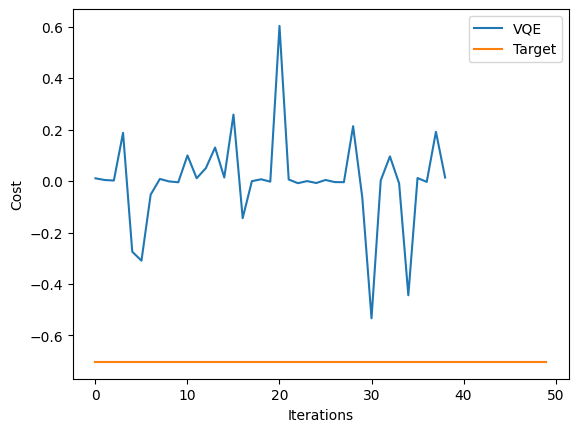

In [16]:
fig, ax = plt.subplots()
x = np.linspace(0, 10, 50)

# Define the constant function
constant = -0.7029
y_constant = np.full_like(x, constant)
ax.plot(
    range(cost_history_dict["iters"]), cost_history_dict["cost_history"], label="VQE"
)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
ax.plot(y_constant, label="Target")
plt.legend()
plt.draw()

IBM Quantum has other upskilling offerings related to VQE. If you are ready to put VQE into practice, see our tutorial: [Variational Quantum Eigensolver](/docs/tutorials/variational-quantum-eigensolver). If you want more information on creating molecular Hamiltonians, see [this lesson](/learning/courses/quantum-chem-with-vqe/hamiltonian-construction) in our course on [Quantum chemistry with VQE](/learning/courses/quantum-chem-with-vqe). If you are interested in a deeper understanding of how variational algorithms like VQE work, we recommend the course [Variational Algorithm Design](/learning/courses/variational-algorithm-design/optimization-loops).


#### Check your understanding
Read the question below, think about your answer, then click the triangle to reveal the solution.

<details>
<summary>

In this section, we calculated a ground state energy from a Hamiltonian. If we wanted to apply this to say, determining the geometry of a molecule, how would we extend this?

</summary>

__Answer:__

We would need to introduce variables for inter-atomic spacing, and the angles between bonds. We would need to vary these. For every variation of these, we would produce a new Hamiltonian (since the operators describing the energy certainly depend on the geometry). For each such Hamiltonian produced and mapped onto qubits, we would need to carry out optimization like that done above. Of all those many converged optimization problems, the geometry that produced the lowest energy would be the one adopted by nature. This is quite a bit more involved than what was shown above. Such a calculation is done for the simplest molecule, $\text{H}_2$, [here](/learning/courses/quantum-chem-with-vqe/geometry).

</details>

## 4. VQE's relationship to other methods

In this section we will review the advantages and disadvantages of the original VQE approach and point out its relationships to other, more recent algorithms.

### 4.1 The strengths and weaknesses of VQE

Some strengths have already been pointed out. They include:

* Suitability to modern hardware: Some quantum algorithms require much lower error rates, approaching large scale fault tolerance. VQE does not; it can be implemented on current quantum computers.
* Shallow circuits: VQE often employs relatively shallow quantum circuits. This makes VQE less susceptible to accumulated gate errors and makes it suitable for many error mitigation techniques. Of course, the circuits are not always shallow; this depends on the ansatz used.
* Versatility: VQE can (in principle) be applied to any problem that can be cast as an eigenvalue/eigenvector problem. There are many caveats that make VQE impractical or disadvantageous for some problems. Some of these are recapped below.

Some weaknesses of VQE and problems for which it is impractical have also been described above. These include:

* Heuristic nature: VQE does not guarantee convergence to the correct ground state energy, as its performance depends on the choice of ansatz and optimization methods[\[1-2\]](#references). If a poor ansatz is chosen that lacks the requisite entanglement for the desired ground state, no classical optimizer can reach that ground state.
* Potentially numerous parameters: A very expressive ansatz may have so many parameters that the minimization iterations are very time-consuming.
* High measurement overhead: In VQE, an estimator is used to estimate the expectation value of each term in the Hamiltonian. Most Hamiltonians of interest will have terms that cannot be simultaneously estimated. This can make VQE resource-intensive for large systems with complicated Hamiltonians[\[1\]](#references).
* Effects of noise: When the classical optimizer is searching for a minimum, noisy calculations can confuse it and steer it away from the true minimum or delay its convergence. One possible solution for this is leveraging IBM's state of the art error mitigation and error suppression techniques[\[2-3\]](#references).
* Barren plateaus: These regions of vanishing gradients[\[2-3\]](#references) exist even in the absence of noise, but noise makes them more troublesome since the change in expectation values due to noise could be larger than the change from updating parameters in these barren regions.

### 4.2 Relationship to other approaches

#### Adapt-VQE

The **ADAPT-VQE** (Adaptive Derivative-Assembled Pseudo-Trotter Variational Quantum Eigensolver) algorithm is an enhancement of the original VQE algorithm, designed to improve efficiency, accuracy, and scalability for quantum simulations, particularly in quantum chemistry.

The original VQE algorithm described throughout this lesson uses a predefined, fixed ansatz to approximate the ground state of the system. In our case, we used `efficient_su2`, with a single repetition, using Y and RZ rotation gates.  Although the parameters in the RZ gates changed, the structure of this ansatz and the gates used did not change.

ADAPT-VQE addresses the limitations of VQE through adaptive ansatz construction. Instead of starting with a fixed ansatz, ADAPT-VQE dynamically builds the ansatz iteratively. At each step, it selects the operator from a predefined pool (such as fermionic excitation operators) that has the largest gradient with respect to the energy. This ensures that only the most impactful operators are added, leading to a compact and efficient ansatz[\[4-6\]](#references). This approach can have several beneficial effects:

1. **Reduced Circuit Depth**: By growing the ansatz incrementally and focusing only on necessary operators, ADAPT-VQE minimizes gate operations compared to traditional VQE approaches[\[5,7\]](#references).
2. **Improved Accuracy**: The adaptive nature allows ADAPT-VQE to recover more correlation energy at each step, making it particularly effective for strongly correlated systems where traditional VQE struggles[\[8,9\]](#references).
3. **Scalability and Noise Robustness**: The compact ansatz reduces the accumulation of gate errors, reduces computational overhead, and limits the number of variational parameters which must be minimized.

ADAPT-VQE is still not perfect. In some cases it can become trapped or slowed by local minima, and it may suffer from over-parameterization. It can also be fairly resource intensive, since it requires the calculation of gradients and parameter optimization with many gate structures.

#### Quantum phase estimation (QPE)

QPE is similar in purpose to VQE, but very different in implementation. QPE requires fault-tolerant quantum computers due to its generally deep quantum circuits and the high level of coherence it requires. Once QPE can be implemented, it would be more precise than VQE. One way of describing the difference is through the precision as a function of circuit depth. QPE achieves precision $\epsilon$ with circuit depths scaling as $O(1/\epsilon)$ [\[10\]](#references). VQE requires $O(1/\epsilon^2)$ samples to achieve the same precision[\[10,11\]](#references).

#### Krylov, SQD, QSCI & others in this course

VQE helped establish quantum algorithms that still depend on classical computers, not just for operating the quantum computer, but for substantial parts of the algorithm. Several such algorithms are the focus of the remainder of this course. Here, we give a cursory explanation of a few, simply to compare and contrast them to VQE. They will be explained in much greater detail in subsequent lessons.

__Krylov quantum diagonalization (KQD)__

__Krylov subspace methods__ are ways of projecting a matrix onto a subspace to reduce its dimension and make it more manageable, while keeping the most important features. One trick in this method is to generate a subspace that keeps these features; it turns out that generating this subspace is closely related to a well-established method on quantum computers called __Trotterization__.

There are a few variants of quantum Krylov methods, but generally the approach is:
* Use the quantum computer to generate a subspace (the Krylov subspace) through Trotterization
* Project the matrix of interest onto that Krylov subspace
* Diagonalize the new projected Hamiltonian using a classical computer

__Sampling-based quantum diagonalization (SQD)__

__Sampling-based quantum diagonalization (SQD)__ is related to the Krylov method in that it also attempts to reduce the dimension of a matrix to be diagonalized while preserving key features. SQD does this in the following way:
* Begin with an initial guess for your ground state and prepare the system in that ground state.
* Use Sampler to sample the bitstrings that make up this state.
* Use the collection of computational basis states from sampler as the subspace onto which you project your matrix of interest.
* Diagonalize the smaller, projected matrix using a classical computer.

This is related to VQE in that it leverages classical and quantum computing for substantial algorithm components. They both also share the requirement that we prepare a good initial guess or ansatz. But the distribution of work between the classical and quantum computers in SQD is more like that of the Krylov method.

In fact, the Krylov method and SQD have recently been combined into the sampling-based Krylov quantum diagonalization (SKQD) method [\[12\]](#references).

__Quantum subspace configuration interaction (QSCI)__

[__Quantum Selected Configuration Interaction (QSCI)__](/docs/guides/qunasys-quri-chemistry)[\[13\]](#references) is an algorithm that produces an approximated ground state of a Hamiltonian by sampling a trial wave function to identify the significant computational basis states to generate a subspace for a classical diagonalization.
Both SQD and QSCI use a quantum computer to construct a reduced subspace.  QSCI's additional strength is in its state preparation, especially in the context of chemistry problems. It leverages various strategies such as using time-evolved states [\[14\]](#references) and a set of chemistry-inspired ansätze. By focusing on efficient state preparation, QSCI reduces quantum computational costs for chemical Hamiltonians while maintaining high fidelity and leveraging the noise robustness from quantum state sampling techniques [\[15\]](#references). QSCI also provides an [adaptive construction technique](/docs/guides/qunasys-quri-chemistry#optimization-based-qsci) which provides more ansätze for a better result.

The default workflow of QSCI for chemistry problem is as follows:
* Build the molecular Hamiltonian using your software of choice (such as SciPy).
* Prepare a QSCI algorithm by selecting a proper initial state and a chemistry-inspired ansatz with a pre-selected set of parameters.
* Sample significant basis states and diagonalize the Hamiltonian using a classical computer to obtain the ground state energy.
* Often one uses configuration recovery [\[16\]](#references) and symmetry post-selection [\[15\]](#references) as a post processing technique.
* Optionally, the workflow of adaptive QSCI has an additional optimization loop from step2 to step3, by using more ansätze with a random initial states.


#### Check your understanding
Read the questions below, think about your answers, then click the triangles to reveal the solutions.

<details>
<summary>

What does VQE have in common with all the other methods listed above (except QPE which is not described in great detail)?

</summary>

__Answer:__

All involve a trial state or wave function of some sort. All work best when the initial guess for this trial state is excellent.

Another correct answer is that they are all easiest to implement when the Hamiltonian is easy to measure (can be sorted into relatively few groups of commuting Pauli operators).

</details>

<details>
<summary>

What does VQE have in common with none of the other methods listed above?

</summary>

__Answer:__

Classical optimizers. None of the others use classical optimization algorithms to select variational parameters.

</details>

## References

[2] https://en.wikipedia.org/wiki/Variational_quantum_eigensolver

[3] https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.19.024047

[4] https://arxiv.org/abs/2111.05176

[6] https://inquanto.quantinuum.com/tutorials/InQ_tut_fe4n2_2.html

[7] https://www.nature.com/articles/s41467-019-10988-2

[8] https://arxiv.org/abs/2210.15438

[9] https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.6.013254

[10] https://arxiv.org/html/2403.09624v1

[11] https://www.nature.com/articles/s42005-023-01312-y

[13] https://arxiv.org/abs/1802.00171

[14] https://arxiv.org/abs/2103.08505

[15] https://arxiv.org/html/2501.09702v1

[16] https://quri-sdk.qunasys.com/docs/examples/quri-algo-vm/qsci/

[17] https://arxiv.org/abs/2412.13839

[18] https://arxiv.org/abs/2302.11320v1

[19] https://arxiv.org/pdf/2405.05068v1